In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from monai.networks.nets import UNETR
from monai.losses import DiceCELoss


print_config()

MONAI version: 1.2.0
Numpy version: 1.24.4
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.21.0
Pillow version: 9.5.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about ins

In [2]:
directory = os.environ.get("SpeleenData")
#root_dir = os.mkdir("spleenData") if directory is None else directory
root_dir = "./spleenData/"
print(root_dir)

./spleenData/


In [3]:
print(root_dir)

./spleenData/


In [4]:


resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [5]:
# reading and sorting image files
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_label = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dict = [{"image": image_name, "label": label_name}
             for image_name, label_name in zip(train_images, train_label)]

In [6]:
# setup train and validationsets
train_files, val_files = data_dict[:-9], data_dict[-9:]

In [7]:
fn_keys = ("image", "label")
train_transforms = Compose([
    LoadImaged(keys=fn_keys),
    EnsureChannelFirstd(keys=fn_keys),
    ScaleIntensityRanged(
        keys="image",
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=fn_keys, source_key="image"),
    Orientationd(keys=fn_keys, axcodes="RAS"),
    Spacingd(keys=fn_keys, pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    RandCropByPosNegLabeld(
        keys=fn_keys,
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    )
])

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


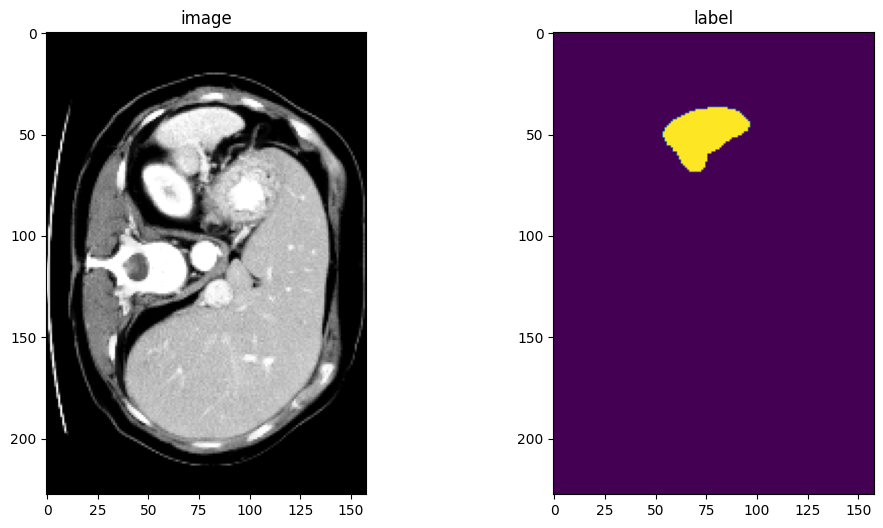

In [8]:
# check Dataloader
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


In [11]:
# Create the model, loss and optimizer
device = torch.device("cpu")
model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [12]:
max_epochs = 6
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                DiceMetric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = DiceMetric.aggregate().item()
            # reset the status for next validation round
            DiceMetric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/6


/home/local/KHQ/s.erattakulangara/anaconda3/envs/runCustomAI/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1/16, train_loss: 4.2129
2/16, train_loss: 4.1643
3/16, train_loss: 4.0879
4/16, train_loss: 4.0345
5/16, train_loss: 4.0006
6/16, train_loss: 3.9814
7/16, train_loss: 3.9254
8/16, train_loss: 3.9126
9/16, train_loss: 3.9055
10/16, train_loss: 3.8664
11/16, train_loss: 3.9032
12/16, train_loss: 3.8636
13/16, train_loss: 3.8413
14/16, train_loss: 3.8104
15/16, train_loss: 3.8249
16/16, train_loss: 3.7967
epoch 1 average loss: 3.9457
----------
epoch 2/6
1/16, train_loss: 3.7779
2/16, train_loss: 3.7861
3/16, train_loss: 3.7494
4/16, train_loss: 3.7425
5/16, train_loss: 3.7165
6/16, train_loss: 3.7118
7/16, train_loss: 3.6786
8/16, train_loss: 3.7010
9/16, train_loss: 3.7170
10/16, train_loss: 3.7343
11/16, train_loss: 3.7054


KeyboardInterrupt: 

In [13]:
val_outputs[0][0].shape

NameError: name 'val_outputs' is not defined

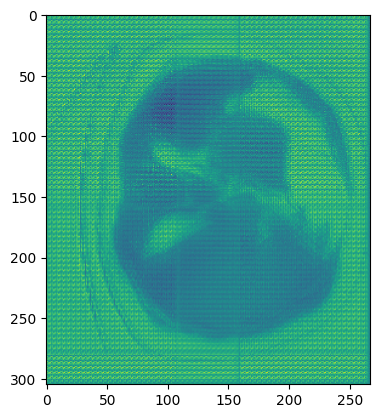

In [ ]:
plt.imshow(val_outputs[0][0][:, :, 80])

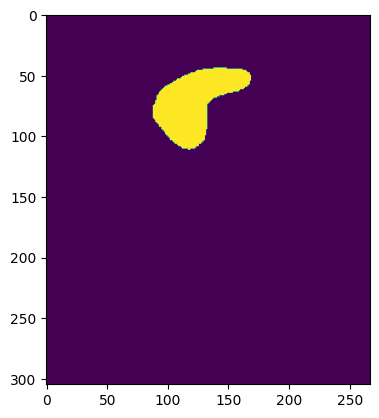

In [ ]:
plt.imshow(val_labels[0][0][:, :, 80])

In [43]:
dice_metric(y_pred=val_outputs, y=val_labels)

metatensor([[0.0186]])